In [9]:
from google.colab import files
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers as ls
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf

import numpy as np
import os, os.path
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')


class MPSRGAN:
    def __init__(self, hr_size=(256, 256), lr_size=(64, 64), channels=3, batch_size=6,
                 train_hr_dir='/content/drive/My Drive/Colab Notebooks/train_hr', 
                 train_lr_dir='/content/drive/My Drive/Colab Notebooks/train_lr', 
                 test_lr_dir='/content/drive/My Drive/Colab Notebooks/test_lr', 
                 test_hr_dir='/content/drive/My Drive/Colab Notebooks/test_hr',
                 discriminator_filters=64, generator_filters=64):
        
        self.hr_size = hr_size
        self.lr_size = lr_size
        self.channels = channels
        self.batch_size = batch_size
        self.train_hr_dir = train_hr_dir
        self.train_lr_dir = train_lr_dir
        # self.valid_hr = ''
        # self.valid_lr = ''
        self.test_lr_dir = test_lr_dir
        self.test_hr_dir = test_hr_dir
        self.generator_filter_size = generator_filters
        self.discriminator_filter_size = discriminator_filters
        self.number_of_train_imgs = len(os.listdir(train_lr_dir + '/train_lr'))
        self.number_of_test_imgs = len(os.listdir(test_lr_dir + '/test_lr'))

        # creating optimizer
        self.optimizer = Adam(0.0002, beta_1=0.9)

        # Creating data loaders
        print("Creating data loaders")
        self.train_generator_lr, self.train_generator_hr, self.test_generator_lr, self.test_generator_hr = self.build_data_generators()
        print("Data loaders ready")

        # Creating model
        print("Building model")
        self.VGG19 = self.build_VGG19()
        self.VGG19.compile(loss='mse', optimizer=self.optimizer)
        print("VGG19 ready")
        self.generator = self.build_generator()
        self.generator.compile(loss='mse', optimizer=self.optimizer)
        print("Generator ready")
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        print("Discriminator ready")
        self.combined = self.build_combined()
        self.combined.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 0.00006], optimizer=self.optimizer)
        print("Combined model ready")

    def PSNR(self, y_true, y_pred):
        return -10.0 * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.0) 

    def build_data_generators(self):
        d = ImageDataGenerator()

        train_generator_lr = d.flow_from_directory(
            self.train_lr_dir,
            target_size=self.lr_size,
            batch_size=self.batch_size,
            class_mode=None,
            shuffle=False)

        train_generator_hr = d.flow_from_directory(
            self.train_hr_dir,
            target_size=self.hr_size,
            batch_size=self.batch_size,
            class_mode=None,
            shuffle=False)
        '''
        self.valid_generator_lr = d.flow_from_directory(
        self.valid_lr,
        target_size = self.lr_size,
        batch_size = self.batch_size,
        class_mode=None,
        shuffle=True)
        self.valid_generator_hr = d.flow_from_directory(
        self.valid_hr,
        target_size = self.hr_size,
        batch_size = self.batch_size,
        class_mode=None,
        shuffle=True)
        '''
        test_generator_lr = d.flow_from_directory(
        self.test_lr_dir,
        target_size = self.lr_size,
        batch_size = 1,
        class_mode=None,
        shuffle=False)

        test_generator_hr = d.flow_from_directory(
        self.test_hr_dir,
        target_size = self.hr_size,
        batch_size = 1,
        class_mode=None,
        shuffle=False)

        return train_generator_lr, train_generator_hr, test_generator_lr, test_generator_hr

    def build_generator(self):
        def residual_block(layer_input, filters):
            d = ls.Conv2D(filters, kernel_size=3, strides=1, padding='same')(layer_input)
            d = ls.Activation('relu')(d)
            d = ls.BatchNormalization(momentum=0.8)(d)
            d = ls.Conv2D(filters, kernel_size=3, strides=1, padding='same')(d)
            d = ls.BatchNormalization(momentum=0.8)(d)
            d = ls.Add()([d, layer_input])
            return d

        def deconv2d(layer_input):
            u = ls.UpSampling2D(size=2)(layer_input)
            u = ls.Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(u)
            u = ls.Activation('relu')(u)
            return u

        img_lr = ls.Input(shape=self.lr_size + (self.channels,))

        c1 = ls.Conv2D(self.generator_filter_size, kernel_size=9, strides=1, padding='same')(img_lr)
        c1 = ls.Activation('relu')(c1)

        r = residual_block(c1, self.generator_filter_size)

        for _ in range(16 - 1):
            r = residual_block(r, self.generator_filter_size)

        c2 = ls.Conv2D(64, kernel_size=3, strides=1, padding='same')(r)
        c2 = ls.BatchNormalization(momentum=0.8)(c2)
        c2 = ls.Add()([c2, c1])

        u1 = deconv2d(c2)
        u2 = deconv2d(u1)

        gen_hr = ls.Conv2D(self.channels, kernel_size=9, strides=1, padding='same', activation='tanh')(u2)

        return Model(img_lr, gen_hr)

    def build_discriminator(self):
        def d_block(layer_input, filters, strides=1, bn=True):
            d = ls.Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
            d = ls.LeakyReLU(alpha=0.2)(d)
            if bn:
                d = ls.BatchNormalization(momentum=0.8)(d)
            return d

        d0 = ls.Input(shape=self.hr_size + (self.channels,))

        d1 = d_block(d0, self.discriminator_filter_size, bn=False)
        d2 = d_block(d1, self.discriminator_filter_size, strides=2)
        d3 = d_block(d2, self.discriminator_filter_size * 2)
        d4 = d_block(d3, self.discriminator_filter_size * 2, strides=2)
        d5 = d_block(d4, self.discriminator_filter_size * 4)
        d6 = d_block(d5, self.discriminator_filter_size * 4, strides=2)
        d7 = d_block(d6, self.discriminator_filter_size * 8)
        d8 = d_block(d7, self.discriminator_filter_size * 8, strides=2)

        d9 = ls.Dense(self.discriminator_filter_size * 16)(d8)
        d10 = ls.LeakyReLU(alpha=0.2)(d9)
        validity = ls.Dense(1, activation='sigmoid')(d10)

        return Model(d0, validity)


    def build_VGG19(self):
        vgg = VGG19(weights="imagenet")
        vgg.outputs = [vgg.layers[9].output]
        img = ls.Input(shape=self.hr_size + (self.channels,))
        img_features = vgg(img)
        model = Model(img, img_features)
        model.trainable = False
        return model

    def build_combined(self):
        img_lr = ls.Input(shape=self.lr_size + (self.channels,))
        fake_hr = self.generator(img_lr)
        self.discriminator.trainable = False
        validity = self.discriminator(fake_hr)
        vgg_input = ls.Lambda(lambda fake_hr: preprocess_input(tf.math.add(fake_hr, 1) * 127.5))(fake_hr)
        fake_features = self.VGG19(vgg_input)

        return Model(img_lr, [validity, fake_features])

    def rescale_to_original(self, x):
        return (x+1)*127.5

    '''def write_log(self, callback, names, logs, batch_no):
        for name, value in zip(names, logs):
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value
            summary_value.tag = name
            callback.writer.add_summary(summary, batch_no)
            callback.writer.flush()'''

    def train(self, epochs=10, show_images=False, show_graph=False, continous_train=False):
        if continous_train:
            self.generator.load_weights('/content/drive/My Drive/Colab Notebooks/generator_weights.h5')
            self.discriminator.load_weights('/content/drive/My Drive/Colab Notebooks/discriminator_weights.h5')

        d_loss_r=[]
        d_loss_f=[]
        g_loss_d=[]
        g_loss_vgg=[]

        print('Start training')
        for cnt in range(epochs):
            '''log_path = '/content/drive/My Drive/Colab Notebooks/logs'
            callback = tf.keras.callbacks.TensorBoard(log_path, histogram_freq=1)
            callback.set_model(self.combined)
            generator_losses = ['Generator loss', 'Generator loss (D)', 'Generator loss (VGG)']
            discriminator_real = ['Discriminator loss (real)']
            discriminator_fake = ['Discriminator loss (fake)']
            val_names = ['val_loss', 'val_mae']'''

            for iteration in range(self.number_of_train_imgs // self.batch_size):
            #for iteration in range(5):
                images_lr = self.train_generator_lr.next()
                images_hr = self.train_generator_hr.next()

                # Process input images
                images_lr = preprocess_input(np.copy(images_lr), mode="tf")
                images_hr_vgg = preprocess_input(np.copy(images_hr))
                images_hr = preprocess_input(np.copy(images_hr), mode="tf")
                
                # Train discriminator
                fake_hr = self.generator.predict_on_batch(images_lr)

                valid = np.ones((len(images_lr),) + (16, 16, 1))
                fake = np.zeros((len(images_lr),) + (16, 16, 1))

                d_loss_real = self.discriminator.train_on_batch(images_hr, valid)
                d_loss_fake = self.discriminator.train_on_batch(fake_hr, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                #self.write_log(callback, discriminator_real, [d_loss_real], iteration)
                #self.write_log(callback, discriminator_fake, [d_loss_fake], iteration)

                # Train generator
                image_features = self.VGG19.predict_on_batch(images_hr_vgg)

                g_loss = self.combined.train_on_batch(images_lr, [valid, image_features])
                #self.write_log(callback, generator_losses, g_loss, iteration)

                if iteration % 1 == 0:
                    d_loss_r.append(d_loss_real)
                    d_loss_f.append(d_loss_fake)
                    g_loss_d.append(g_loss[1])
                    g_loss_vgg.append(g_loss[2])


            print ('epoch: {} Discriminator loss: {}  Generator loss (D): {} Generator loss (VGG): {}'.format((cnt+1), d_loss, g_loss[1], g_loss[2]))

            if show_images:
                plt.figure(figsize= (15, 15))
                plt.subplot(1,3,1)
                plt.title('original')
                plt.imshow(self.rescale_to_original(images_hr[0]).astype(np.uint8))

                plt.subplot(1,3,2)
                plt.title('generated: %d. epoch' % (cnt+1))
                plt.imshow(self.rescale_to_original(fake_hr[0]).astype(np.uint8))

                plt.subplot(1,3,3)
                plt.title('input')
                plt.imshow(self.rescale_to_original(images_lr[0]).astype(np.uint8))
                plt.show()

        if show_graph:
            plt.figure(figsize=(20, 5))
            plt.subplot(1,3,1)
            plt.title('Discriminator losses')
            plt.plot(d_loss_r, label='Discriminator loss (real imgs)')
            plt.plot(d_loss_f, label='Discriminator loss (fake imgs)')
            plt.legend()

            plt.subplot(1,3,2)
            plt.title('Generator loss (D)')
            plt.plot(g_loss_d)

            plt.subplot(1,3,3)
            plt.title('Generator loss (VGG)')
            plt.plot(g_loss_vgg)
            plt.show()

        self.generator.save_weights('/content/drive/My Drive/Colab Notebooks/Generator weights/generator_weights_epoch{}_iter{}.h5'.format(cnt+1, iteration+1))
        self.discriminator.save_weights('/content/drive/My Drive/Colab Notebooks/Discriminator weights/discriminator_weights_epoch{}_iter{}.h5'.format(cnt+1, iteration+1))


    def test(self):
        self.generator.load_weights('/content/drive/My Drive/Colab Notebooks/generator_weights.h5')
        self.discriminator.load_weights('/content/drive/My Drive/Colab Notebooks/discriminator_weights.h5')

        for _ in range(self.number_of_test_imgs):
            images_lr = self.test_generator_lr.next()
            images_hr = self.test_generator_hr.next()

            # Process input images
            images_lr = preprocess_input(np.copy(images_lr), mode="tf")
            images_hr_vgg = preprocess_input(np.copy(images_hr))
            images_hr = preprocess_input(np.copy(images_hr), mode="tf")

            image_features = self.VGG19.predict_on_batch(images_hr_vgg)
            fake_hr = self.generator.predict_on_batch(images_lr)
            valid = np.ones((len(images_lr),) + (16, 16, 1))

            test_loss = self.combined.test_on_batch(images_lr, [valid, image_features])
            print(test_loss)

            plt.figure( figsize= ( 15, 15))
            plt.subplot(1,3,1)
            plt.title('original')
            plt.imshow(self.rescale_to_original(images_hr[0]).astype(np.uint8))

            plt.subplot(1,3,2)
            plt.title('generated')
            plt.imshow(self.rescale_to_original(fake_hr[0]).astype(np.uint8))

            plt.subplot(1,3,3)
            plt.title('input')
            plt.imshow(self.rescale_to_original(images_lr[0]).astype(np.uint8))

            plt.show()
        




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
srgan = MPSRGAN()

Creating data loaders
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.
Data loaders ready
Building model
VGG19 ready
Generator ready
Discriminator ready
Combined model ready


Start training


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 1 Discriminator loss: 0.9722681045532227  Generator loss (D): 1.8418986797332764 Generator loss (VGG): 72542.21875


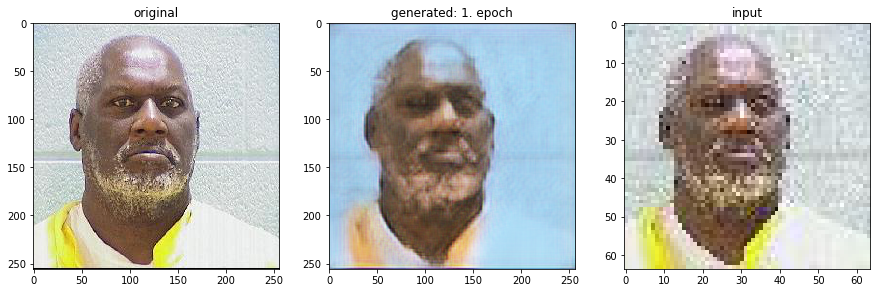

epoch: 2 Discriminator loss: 0.30866989493370056  Generator loss (D): 4.979202747344971 Generator loss (VGG): 44386.875


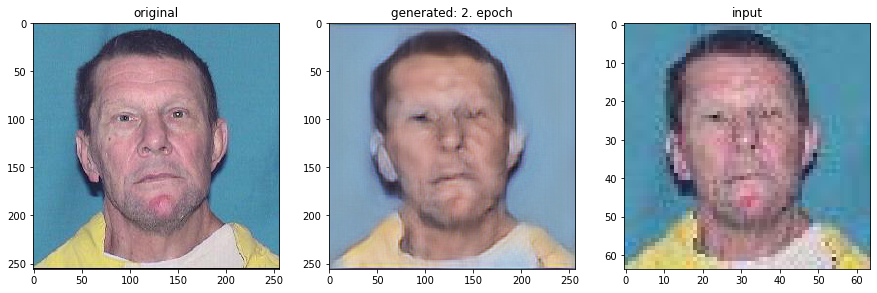

epoch: 3 Discriminator loss: 0.470543771982193  Generator loss (D): 1.255832314491272 Generator loss (VGG): 48657.60546875


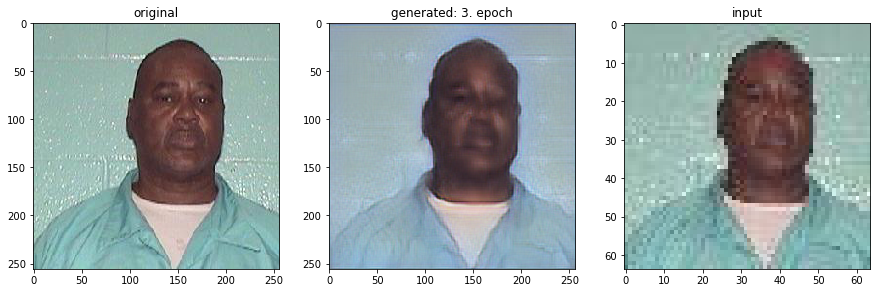

epoch: 4 Discriminator loss: 0.03757792338728905  Generator loss (D): 5.129989147186279 Generator loss (VGG): 40821.484375


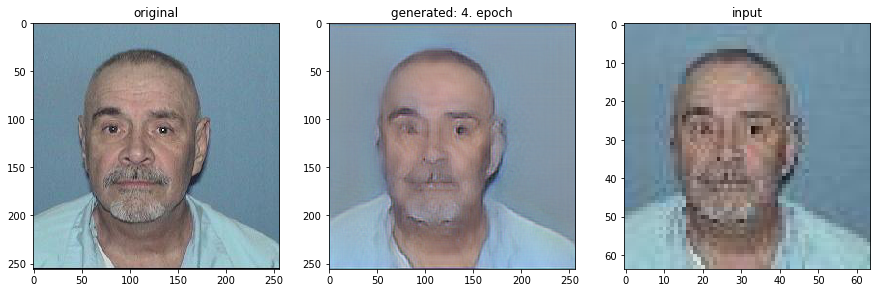

epoch: 5 Discriminator loss: 0.21106988191604614  Generator loss (D): 4.802344799041748 Generator loss (VGG): 43152.47265625


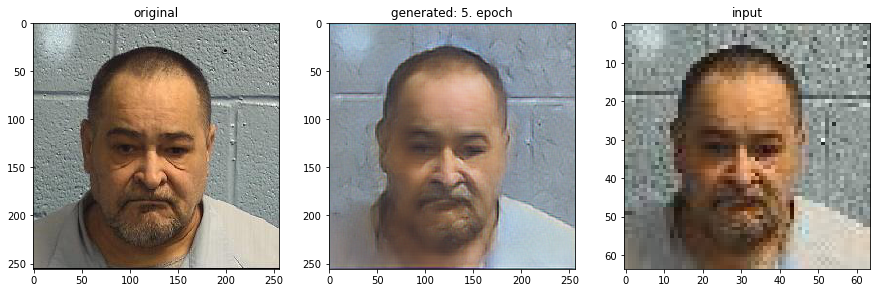

epoch: 6 Discriminator loss: 0.11474475264549255  Generator loss (D): 1.970682978630066 Generator loss (VGG): 38432.875


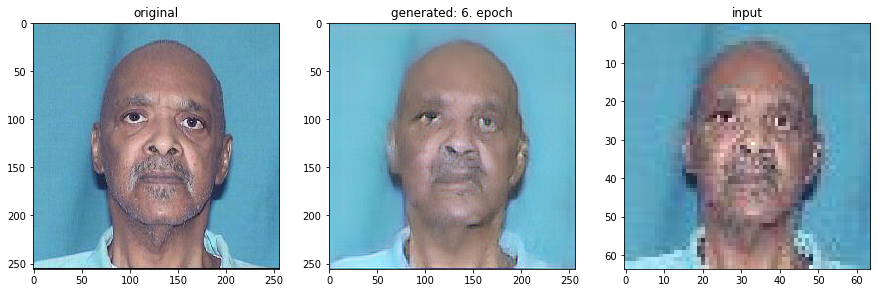

epoch: 7 Discriminator loss: 0.793068528175354  Generator loss (D): 2.858271837234497 Generator loss (VGG): 36977.51171875


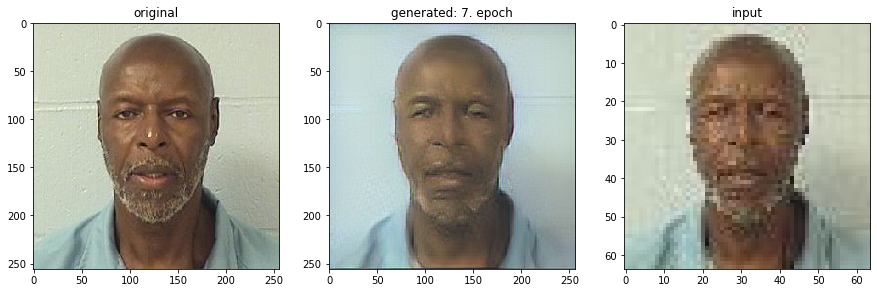

epoch: 8 Discriminator loss: 0.25237134099006653  Generator loss (D): 4.7079386711120605 Generator loss (VGG): 35144.76953125


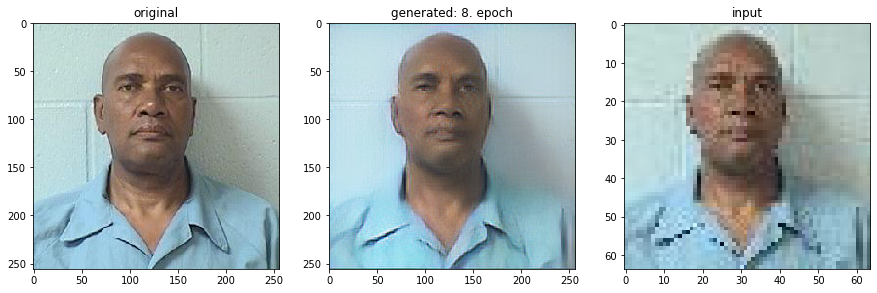

epoch: 9 Discriminator loss: 0.18742825090885162  Generator loss (D): 3.41391658782959 Generator loss (VGG): 41919.921875


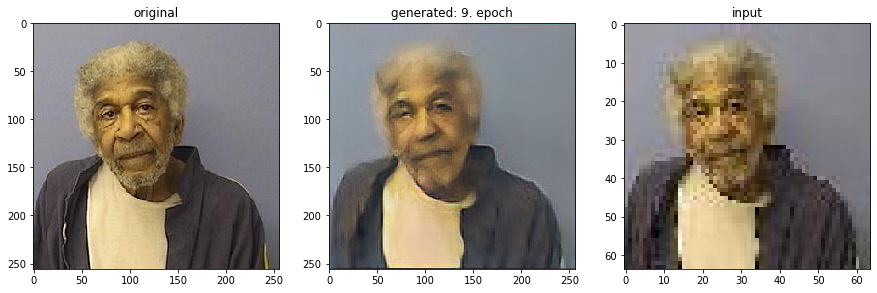

epoch: 10 Discriminator loss: 0.03886488825082779  Generator loss (D): 5.0029473304748535 Generator loss (VGG): 34427.16796875


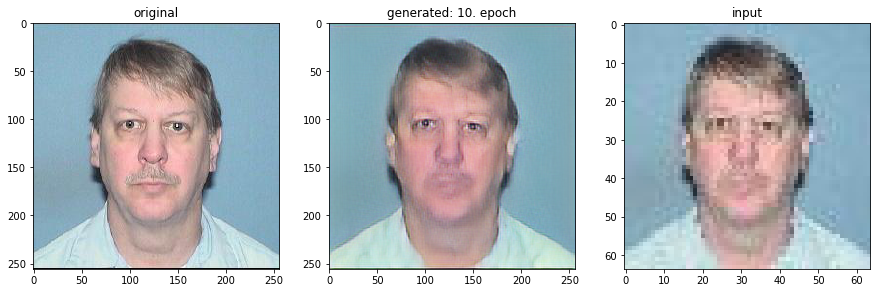

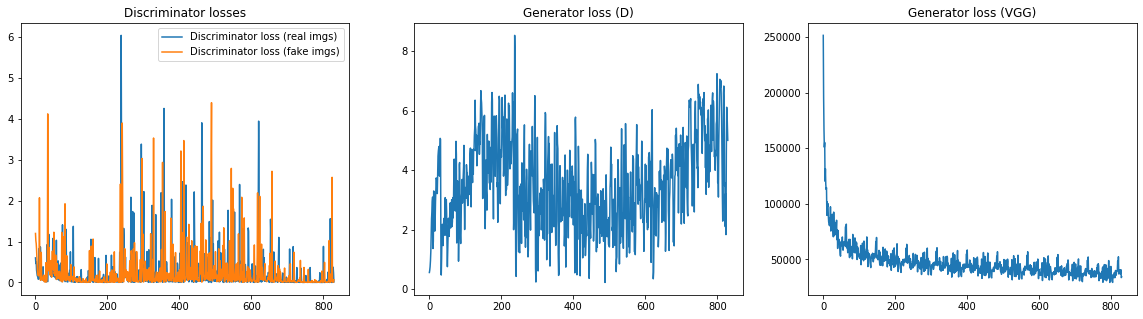

OSError: ignored

In [12]:
srgan.train(epochs=10, show_images=True, show_graph=True, continous_train=False)

[2.653003, 9.315538, 44061.46]


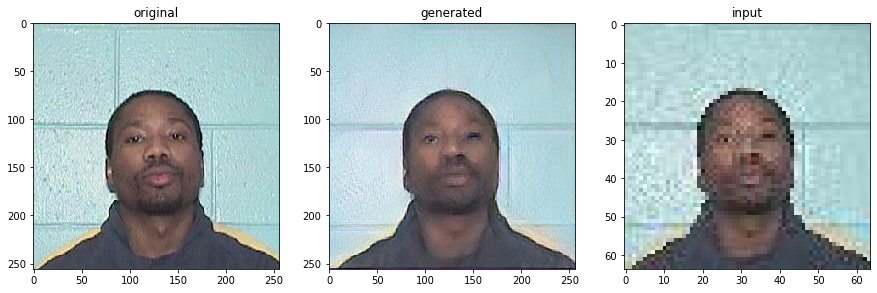

[2.387678, 8.602876, 39651.25]


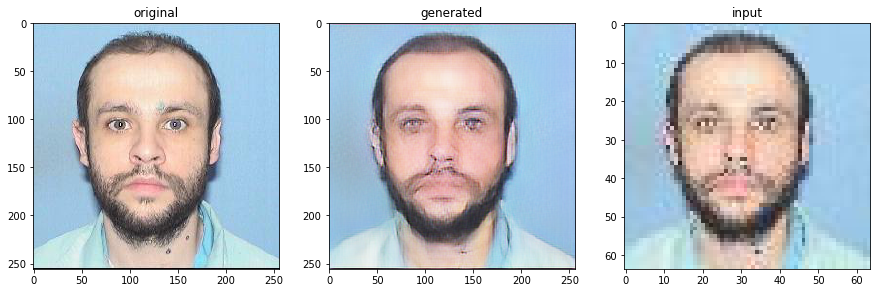

[1.3712457, 6.1069994, 22752.312]


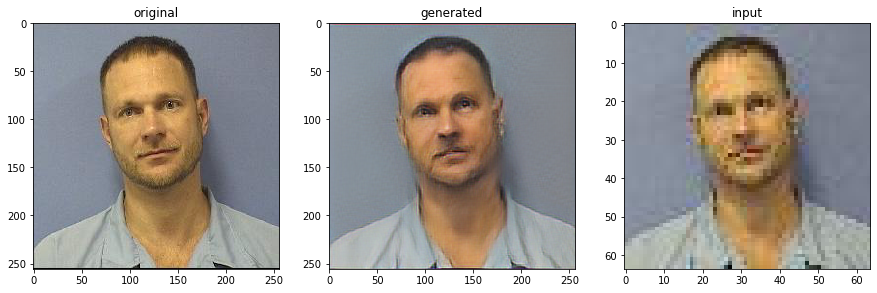

[2.7143633, 10.370546, 45066.547]


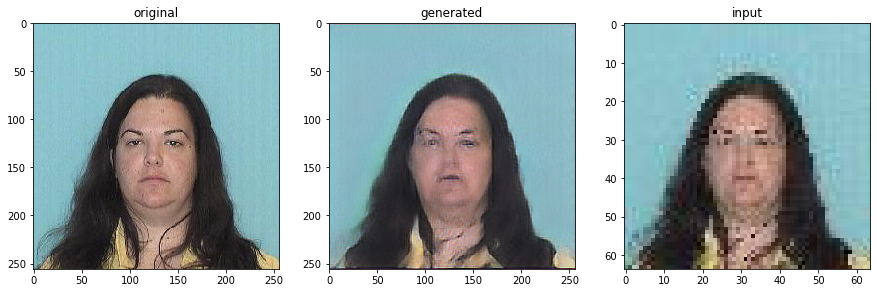

[3.54523, 8.558642, 58944.52]


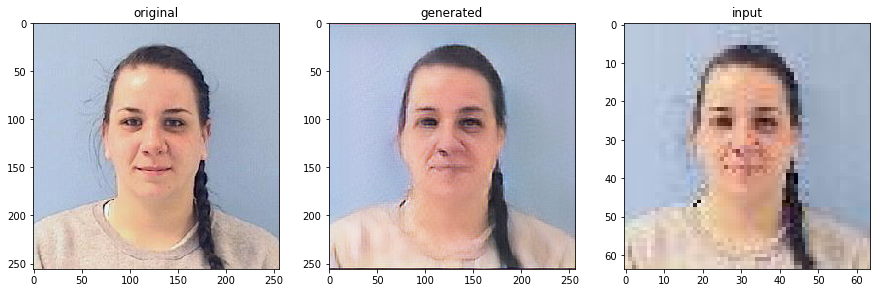

[1.9735034, 8.483164, 32750.338]


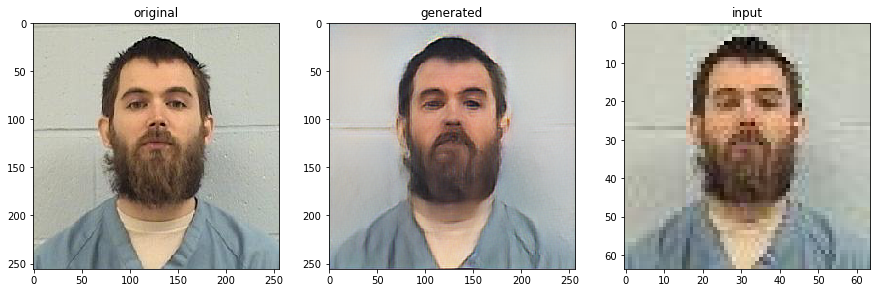

[2.088379, 9.060626, 34655.305]


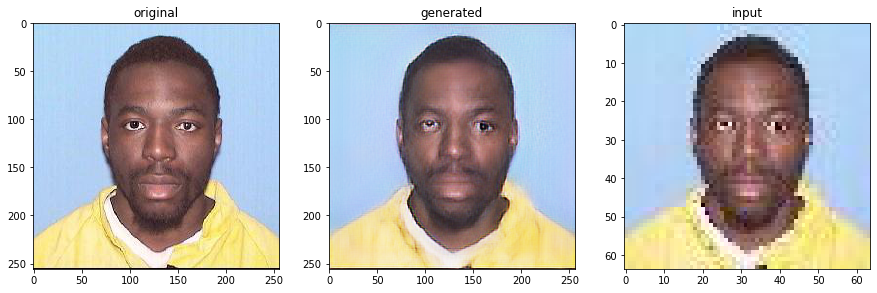

[1.5780761, 7.285222, 26179.85]


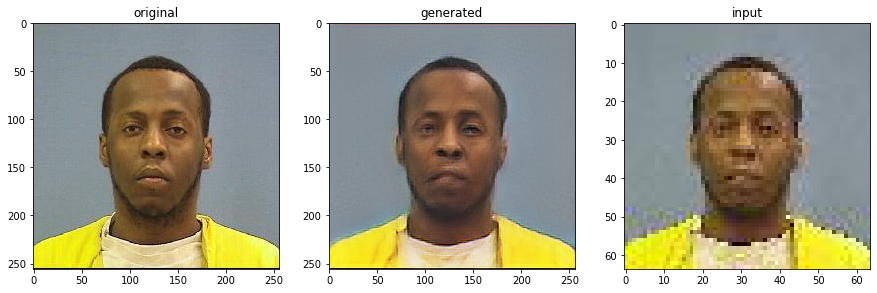

[4.0799785, 10.897594, 67818.016]


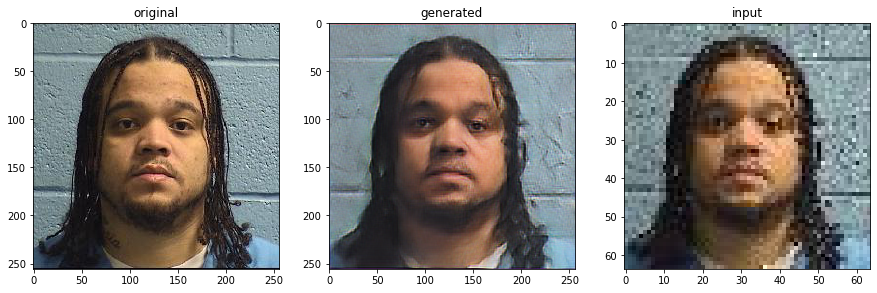

[2.3250644, 9.935806, 38585.477]


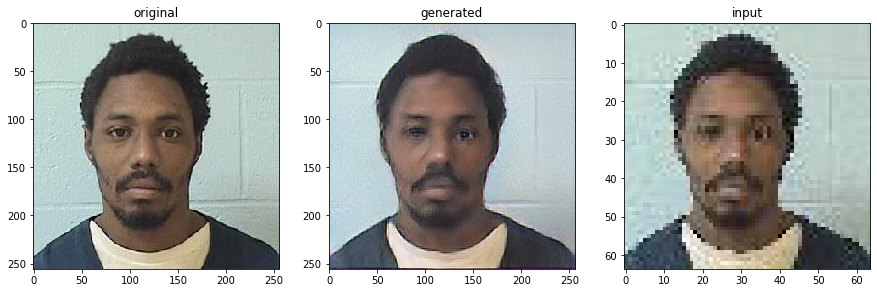

In [30]:
srgan.test()

In [0]:
%load_ext tensorboard.notebook
%tensorboard --logdir '/content/drive/My Drive/Colab Notebooks/logs'